# Data preprocessing

## Import libraries
Let's start with the libraries I am going to use, import them and see the versions I used

In [1]:
# Import libraries
import gc
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
%matplotlib inline
import seaborn as sns
from time import sleep
from tqdm import notebook

# Libraries version
print("VERSIONS:")
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Seaborn: ", sns.__version__)
plt = matplotlib.pyplot

# Input data files are available in the "../input/competitive-data-science-predict-future-sales" directory.
import os
print("\nDATA:")
print(os.listdir("data"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

VERSIONS:
Numpy:  1.19.3
Pandas:  1.1.4
Matplotlib:  3.3.3
Seaborn:  0.11.0

DATA:
['items.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


## Read data

In [2]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
item_categories = pd.read_csv('data/item_categories.csv')

# This list is going to help us later
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

Let's see what we have in the data

In [3]:
items.head(items.shape[0])

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [4]:
shops.head(shops.shape[0])

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [5]:
test.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [6]:
sample_submission.head(10)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
5,5,0.5
6,6,0.5
7,7,0.5
8,8,0.5
9,9,0.5


In [7]:
item_categories.head(item_categories.shape[0])

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


Let's plot sales_train

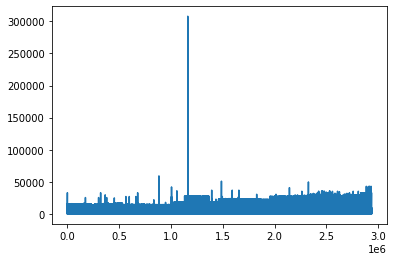

In [8]:
plt.plot(sales_train.item_price)
plt.show()

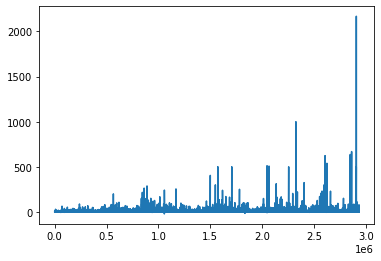

In [9]:
plt.plot(sales_train.item_cnt_day)
plt.show()

In [10]:
sales_train.sort_values(by=['item_price'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0000,1.0
608763,08.06.2013,5,58,11865,0.0700,1.0
579766,11.06.2013,5,6,11864,0.0700,1.0
611400,08.06.2013,5,58,20146,0.0875,4.0
673155,31.07.2013,6,6,11872,0.0900,1.0
...,...,...,...,...,...,...
2910156,29.10.2015,33,12,13403,42990.0000,1.0
2327159,29.01.2015,24,12,7241,49782.0000,1.0
1488135,20.03.2014,14,25,13199,50999.0000,1.0
885138,17.09.2013,8,12,11365,59200.0000,1.0


As we can see in the above plots, there are some values too big and also we can see when we sort the prices some negative values and as every one knows negative prices doesn't exists

So, the first thing to do is remove those values that are too big
Second, calculate median that is going to be the new value for the negative item, this is calculated by taking the same shop id, item id, date block and all values greater than 0

In [11]:
sales_train = sales_train[sales_train.item_price < 100000]
sales_train = sales_train[sales_train.item_cnt_day < 1001]

median = sales_train[(sales_train.shop_id == 32) & (sales_train.item_id == 2973) & (sales_train.date_block_num == 4) & (
            sales_train.item_price > 0)].item_price.median()
sales_train.loc[sales_train.item_price < 0, 'item_price'] = median

In [12]:
print(shops.shop_name[shops.shop_id == 0])
print(shops.shop_name[shops.shop_id == 57])
print(shops.shop_name[shops.shop_id == 1])
print(shops.shop_name[shops.shop_id == 58])
print(shops.shop_name[shops.shop_id == 10])
print(shops.shop_name[shops.shop_id == 11])

0    !Якутск Орджоникидзе, 56 фран
Name: shop_name, dtype: object
57    Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1    !Якутск ТЦ "Центральный" фран
Name: shop_name, dtype: object
58    Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
10    Жуковский ул. Чкалова 39м?
Name: shop_name, dtype: object
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object


As you can see above the shops looks like there are the same, then, now, Im going to modify their ids to be the same

In [13]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

test['date_block_num'] = 34

In [14]:
test.head(10)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
5,5,5,5039,34
6,6,5,5041,34
7,7,5,5046,34
8,8,5,5319,34
9,9,5,5003,34


## Features

Now it's time to create new features

Let's start adding category to train

In [15]:
category = items[['item_id', 'item_category_id']].drop_duplicates()
category.set_index(['item_id'], inplace=True)
category = category.item_category_id
sales_train['category'] = sales_train.item_id.map(category)

Let's split the name of the category to create meta category, this is made because if you translate the "item_category_name" you can see that the first word is the category and the second is the element that belongs to the category, but let me show you some examples before to split the data

**Example**

The "item_category_name" for item_category_id 1 is Аксессуары - PS2, if we translated it to English is Accessories - PS2

In [16]:
item_categories['meta_category'] = item_categories.item_category_name.apply(lambda x: x.split(' ')[0])
item_categories['meta_category'] = pd.Categorical(item_categories.meta_category).codes
item_categories.set_index(['item_category_id'], inplace=True)
meta_category = item_categories.meta_category
sales_train['meta_category'] = sales_train.category.map(meta_category)

Another feature we can take is the city for very shop, if you search on google the name of the shop that appears in the "shop_name" column you can see that the first word corresponds to a city, then, we take it as a feature

In [17]:
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
sales_train['city'] = sales_train.shop_id.map(city)

Let's take the year and months for date_block_num

In [18]:
year = pd.concat([sales_train.date_block_num, sales_train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append(pd.Series([2015], index=[34]))

In [19]:
month = pd.concat([sales_train.date_block_num, sales_train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append(pd.Series([11], index=[34]))

Let's create a new data frame for unique shops and items for every date_block_num

In [20]:
all_shops_items = []

for block_num in sales_train['date_block_num'].unique():
    unique_shops = sales_train[sales_train['date_block_num'] == block_num]['shop_id'].unique()
    unique_items = sales_train[sales_train['date_block_num'] == block_num]['item_id'].unique()
    all_shops_items.append(np.array(list(itertools.product([block_num], unique_shops, unique_items)), dtype='int32'))

df = pd.DataFrame(np.vstack(all_shops_items), columns=groupby_cols, dtype='int32')
df = df.append(test, sort=True)

Now it's time to fix every NaN value and also add the columns I created previously

In [21]:
df['ID'] = df.ID.fillna(-1).astype('int32')
df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['category'] = df.item_id.map(category)
df['meta_category'] = df.category.map(meta_category)
df['city'] = df.shop_id.map(city)
sales_train['category'] = sales_train.item_id.map(category)

## Add target features

In [22]:
%%time

# Sum item_cnt_day values and define the column as general target
# Group by date_block_num, shop_id, item_id
gb = sales_train.groupby(by=groupby_cols, as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target'}, inplace=True)
# Add the target column to the data frame
df = pd.merge(df, gb, how='left', on=groupby_cols)

# Sum item_cnt_day values and define the column as target for items
# Group by date_block_num, item_id
gb = sales_train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_item'}, inplace=True)
# Add the target column to the data frame
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

# Sum item_cnt_day values and define the column as target for shops
# Group by date_block_num, shop_id
gb = sales_train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_shop'}, inplace=True)
# Add the target column to the data frame
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

# Sum item_cnt_day values and define the column as target for categories
# Group by date_block_num, category
gb = sales_train.groupby(by=['date_block_num', 'category'], as_index=False).agg({'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum': 'target_category'}, inplace=True)
# Add the target column to the data frame
df = pd.merge(df, gb, how='left', on=['date_block_num', 'category'])

# Now calculate the mean and max item_price and define the columns
# Group by date_block_num and item_id
gb = sales_train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price': ['mean', 'max']})
gb.columns = [val[0] if val[-1] == '' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean': 'target_price_mean', 'item_price_max': 'target_price_max'}, inplace=True)
# Add the mean and max to the data frame
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

df

Wall time: 14.4 s


,ID,date_block_num,item_id,shop_id,year,month,category,meta_category,city,target,target_item,target_shop,target_category,target_price_mean,target_price_max
0,-1,0,22154,59,2013,1,37,7,30,1.0,18.0,2017.0,6094.0,999.00,999.00
1,-1,0,2552,59,2013,1,58,9,30,NaN,0.0,2017.0,287.0,899.00,899.00
2,-1,0,2554,59,2013,1,58,9,30,NaN,1.0,2017.0,287.0,1709.05,1709.05
3,-1,0,2555,59,2013,1,56,9,30,NaN,2.0,2017.0,268.0,1098.85,1099.00
4,-1,0,2564,59,2013,1,59,9,30,NaN,5.0,2017.0,701.0,327.60,349.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,214195,34,18454,45,2015,11,55,9,20,NaN,NaN,NaN,NaN,NaN,NaN
11128000,214196,34,16188,45,2015,11,64,10,20,NaN,NaN,NaN,NaN,NaN,NaN
11128001,214197,34,15757,45,2015,11,55,9,20,NaN,NaN,NaN,NaN,NaN,NaN
11128002,214198,34,19648,45,2015,11,40,7,20,NaN,NaN,NaN,NaN,NaN,NaN


Now that I have added some features to the data frame, let's fix it

In [23]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype('int32')

df

,ID,date_block_num,item_id,shop_id,year,month,category,meta_category,city,target,target_item,target_shop,target_category,target_price_mean,target_price_max,target_zero
0,-1,0,22154,59,2013,1,37,7,30,1.0,18.0,2017.0,6094.0,999.00,999.00,1
1,-1,0,2552,59,2013,1,58,9,30,0.0,0.0,2017.0,287.0,899.00,899.00,0
2,-1,0,2554,59,2013,1,58,9,30,0.0,1.0,2017.0,287.0,1709.05,1709.05,0
3,-1,0,2555,59,2013,1,56,9,30,0.0,2.0,2017.0,268.0,1098.85,1099.00,0
4,-1,0,2564,59,2013,1,59,9,30,0.0,5.0,2017.0,701.0,327.60,349.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,214195,34,18454,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.00,0.00,0
11128000,214196,34,16188,45,2015,11,64,10,20,0.0,0.0,0.0,0.0,0.00,0.00,0
11128001,214197,34,15757,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.00,0.00,0
11128002,214198,34,19648,45,2015,11,40,7,20,0.0,0.0,0.0,0.0,0.00,0.00,0


## Features encoding

Now let's encode the features

In [24]:
%%time

for enc_cols in [['shop_id', 'category'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:

    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    print("COL: ", col)
    print("COL2: ", col2)
    df[col] = np.nan
    df[col2] = np.nan

    for d in notebook.tqdm(df.date_block_num.unique()):
        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left')[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']

        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left')[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']

df

COL:  enc_shop_id_category
COL2:  enc_max_shop_id_category



COL:  enc_shop_id_item_id
COL2:  enc_max_shop_id_item_id



COL:  enc_shop_id
COL2:  enc_max_shop_id



COL:  enc_item_id
COL2:  enc_max_item_id



Wall time: 5min 3s


,ID,date_block_num,item_id,shop_id,year,month,category,meta_category,city,target,target_item,target_shop,target_category,target_price_mean,target_price_max,target_zero,enc_shop_id_category,enc_max_shop_id_category,enc_shop_id_item_id,enc_max_shop_id_item_id,enc_shop_id,enc_max_shop_id,enc_item_id,enc_max_item_id
0,-1,0,22154,59,2013,1,37,7,30,1.0,18.0,2017.0,6094.0,999.00,999.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,0,2552,59,2013,1,58,9,30,0.0,0.0,2017.0,287.0,899.00,899.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,0,2554,59,2013,1,58,9,30,0.0,1.0,2017.0,287.0,1709.05,1709.05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,0,2555,59,2013,1,56,9,30,0.0,2.0,2017.0,268.0,1098.85,1099.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,0,2564,59,2013,1,59,9,30,0.0,5.0,2017.0,701.0,327.60,349.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,214195,34,18454,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.00,0.00,0,0.139436,9.0,0.818182,4.0,0.169654,20.0,1.036072,13.0
11128000,214196,34,16188,45,2015,11,64,10,20,0.0,0.0,0.0,0.0,0.00,0.00,0,0.236397,10.0,0.000000,0.0,0.169654,20.0,0.045977,1.0
11128001,214197,34,15757,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.00,0.00,0,0.139436,9.0,0.205882,2.0,0.169654,20.0,0.233291,4.0
11128002,214198,34,19648,45,2015,11,40,7,20,0.0,0.0,0.0,0.0,0.00,0.00,0,0.121610,20.0,0.000000,0.0,0.169654,20.0,0.112224,4.0


## Downcast

Now it's time to downcast the data types of the data frame

In [25]:
df.dtypes

ID                            int32
date_block_num                int64
item_id                       int64
shop_id                       int64
year                          int64
month                         int64
category                      int64
meta_category                  int8
city                           int8
target                      float64
target_item                 float64
target_shop                 float64
target_category             float64
target_price_mean           float64
target_price_max            float64
target_zero                   int32
enc_shop_id_category        float64
enc_max_shop_id_category    float64
enc_shop_id_item_id         float64
enc_max_shop_id_item_id     float64
enc_shop_id                 float64
enc_max_shop_id             float64
enc_item_id                 float64
enc_max_item_id             float64
dtype: object

In [26]:
def downcast_dtypes(df):
    float32_cols = [c for c in df if df[c].dtype == 'float64']
    int32_cols = [c for c in df if df[c].dtype in ['int64', 'int16', 'int8']]

    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols] = df[int32_cols].astype(np.int32)

    return df

df.fillna(0, inplace=True)
df = downcast_dtypes(df)

In [27]:
df.dtypes

ID                            int32
date_block_num                int32
item_id                       int32
shop_id                       int32
year                          int32
month                         int32
category                      int32
meta_category                 int32
city                          int32
target                      float32
target_item                 float32
target_shop                 float32
target_category             float32
target_price_mean           float32
target_price_max            float32
target_zero                   int32
enc_shop_id_category        float32
enc_max_shop_id_category    float32
enc_shop_id_item_id         float32
enc_max_shop_id_item_id     float32
enc_shop_id                 float32
enc_max_shop_id             float32
enc_item_id                 float32
enc_max_item_id             float32
dtype: object

## Lag features

Now let's create lag features

In [28]:
%%time

shift_range = [1, 2, 3, 4, 5, 12]

shifted_columns = [c for c in df if 'target' in c]

for shift in notebook.tqdm(shift_range):
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)

    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)
df


Wall time: 1min 30s


,ID,date_block_num,item_id,shop_id,year,month,category,meta_category,city,target,target_item,target_shop,target_category,target_price_mean,target_price_max,target_zero,enc_shop_id_category,enc_max_shop_id_category,enc_shop_id_item_id,enc_max_shop_id_item_id,enc_shop_id,enc_max_shop_id,enc_item_id,enc_max_item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_category_lag_1,target_price_mean_lag_1,target_price_max_lag_1,target_zero_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_category_lag_2,target_price_mean_lag_2,target_price_max_lag_2,target_zero_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_category_lag_3,target_price_mean_lag_3,target_price_max_lag_3,target_zero_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_category_lag_4,target_price_mean_lag_4,target_price_max_lag_4,target_zero_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_category_lag_5,target_price_mean_lag_5,target_price_max_lag_5,target_zero_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,target_category_lag_12,target_price_mean_lag_12,target_price_max_lag_12,target_zero_lag_12
0,-1,0,22154,59,2013,1,37,7,30,1.0,18.0,2017.0,6094.0,999.000000,999.000000,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1,0,2552,59,2013,1,58,9,30,0.0,0.0,2017.0,287.0,899.000000,899.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1,0,2554,59,2013,1,58,9,30,0.0,1.0,2017.0,287.0,1709.050049,1709.050049,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1,0,2555,59,2013,1,56,9,30,0.0,2.0,2017.0,268.0,1098.849976,1099.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1,0,2564,59,2013,1,59,9,30,0.0,5.0,2017.0,701.0,327.600006,349.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,214195,34,18454,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0.139436,9.0,0.818182,4.0,0.169654,20.0,1.036072,13.0,1.0,2.0,702.0,5808.0,99.000000,99.0,1.0,0.0,1.0,654.0,4913.0,99.000000,99.0,0.0,0.0,3.0,710.0,6022.0,99.00000,99.0,0.0,0.0,12.0,675.0,6474.0,99.0,99.0,0.0,0.0,19.0,622.0,6017.0,98.947365,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128000,214196,34,16188,45,2015,11,64,10,20,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0.236397,10.0,0.000000,0.0,0.169654,20.0,0.045977,1.0,0.0,1.0,702.0,870.0,1359.000000,1359.0,0.0,0.0,3.0,654.0,801.0,1222.966675,1223.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128001,214197,34,15757,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0.139436,9.0,0.205882,2.0,0.169654,20.0,0.233291,4.0,0.0,5.0,702.0,5808.0,229.000000,229.0,0.0,0.0,3.0,654.0,4913.0,229.000000,229.0,0.0,0.0,4.0,710.0,6022.0,229.00000,229.0,0.0,0.0,4.0,675.0,6474.0,229.0,229.0,0.0,0.0,8.0,622.0,6017.0,22

## Features Interaction

Now let's interact with the lag features previously created

In [29]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1'] * 2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2']) * 2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']
df

,ID,date_block_num,item_id,shop_id,year,month,category,meta_category,city,target,target_item,target_shop,target_category,target_price_mean,target_price_max,target_zero,enc_shop_id_category,enc_max_shop_id_category,enc_shop_id_item_id,enc_max_shop_id_item_id,enc_shop_id,enc_max_shop_id,enc_item_id,enc_max_item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_category_lag_1,target_price_mean_lag_1,target_price_max_lag_1,target_zero_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_category_lag_2,target_price_mean_lag_2,target_price_max_lag_2,target_zero_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_category_lag_3,target_price_mean_lag_3,target_price_max_lag_3,target_zero_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_category_lag_4,target_price_mean_lag_4,target_price_max_lag_4,target_zero_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_category_lag_5,target_price_mean_lag_5,target_price_max_lag_5,target_zero_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,target_category_lag_12,target_price_mean_lag_12,target_price_max_lag_12,target_zero_lag_12,target_trend_1_2,target_predict_1_2,target_trend_3_4,target_predict_3_4,target_item_trend_1_2,target_item_trend_3_4,target_shop_trend_1_2,target_shop_trend_3_4
0,-1,0,22154,59,2013,1,37,7,30,1.0,18.0,2017.0,6094.0,999.000000,999.000000,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1,0,2552,59,2013,1,58,9,30,0.0,0.0,2017.0,287.0,899.000000,899.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1,0,2554,59,2013,1,58,9,30,0.0,1.0,2017.0,287.0,1709.050049,1709.050049,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1,0,2555,59,2013,1,56,9,30,0.0,2.0,2017.0,268.0,1098.849976,1099.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1,0,2564,59,2013,1,59,9,30,0.0,5.0,2017.0,701.0,327.600006,349.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,214195,34,18454,45,2015,11,55,9,20,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0.139436,9.0,0.818182,4.0,0.169654,20.0,1.036072,13.0,1.0,2.0,702.0,5808.0,99.000000,99.0,1.0,0.0,1.0,654.0,4913.0,99.000000,99.0,0.0,0.0,3.0,710.0,6022.0,99.00000,99.0,0.0,0.0,12.0,675.0,6474.0,99.0,99.0,0.0,0.0,19.0,622.0,6017.0,98.947365,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,-12.0,48.0,-29.0
11128000,214196,34,16188,45,2015,11,64,10,20,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0.236397,10.0,0.000000,0.0,0.169654,20.0,0.045977,1.0,0.0,1.0,702.0,870.0,1359.000000,1359.0,0.0,0.0,3.0,654.0,801.0,1222.966675,1223.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Save processed data

Now it's time to save the data frame

In [30]:
df = downcast_dtypes(df)
df.to_pickle('data-pre/df.pkl')